In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [64]:
phys_space = np.random.randn(500,1)
feat_space = np.random.randn(500,3)

np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)

In [65]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val

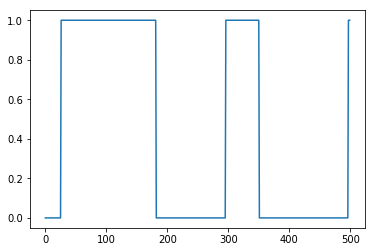

In [68]:
plt.plot(latent_1D);

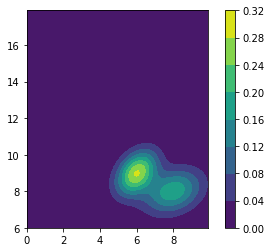

In [70]:
c1 = scipy.stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])
c2 = scipy.stats.multivariate_normal([8,8], [[1.125, 0.225],[0.225, 0.675]])

x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Sample Data

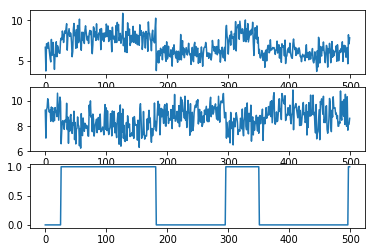

In [6]:
obs = np.empty((len(phys_space[:,0]), 2))
for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
        
fig, ax = plt.subplots(3,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(latent_1D)

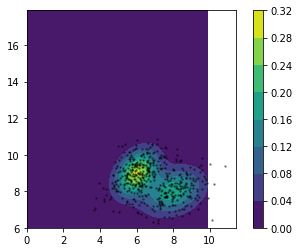

In [7]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(obs[:,0], obs[:,1], c='black', s=2, alpha=0.4)

## Try

In [8]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs)

In [9]:
ex1.fit(100)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


In [10]:
a = np.array(ex1.labels)

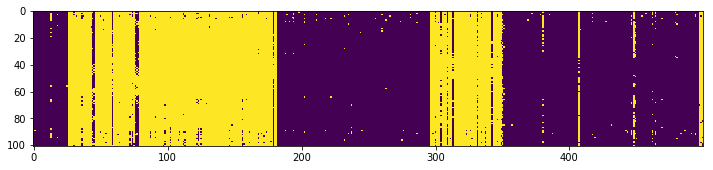

In [11]:
plt.figure(figsize = (12,4))
plt.imshow(a)

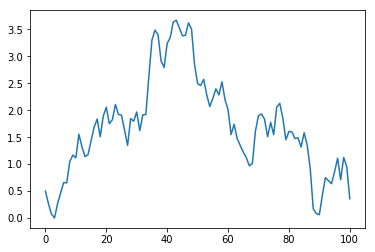

In [12]:
plt.plot(ex1.betas)

In [13]:
np.max(ex1.betas)

3.6697910773774804

In [21]:
ex1.mus[12]

array([[ 5.90263117,  9.14345733],
       [ 8.25592326,  7.99963641]])

In [24]:
ex1.mus[12][:,0]

array([ 5.90263117,  8.25592326])

In [22]:
plt.plot(ex1.mus[:][:,0])

TypeError: list indices must be integers or slices, not tuple

In [16]:
np.mean(ex1.mus[50:])

7.7722543961918928

In [25]:
ex1.covs[12]

array([[[ 0.68062596,  0.29726327],
        [ 0.29726327,  0.63665378]],

       [[ 0.82445571,  0.24944777],
        [ 0.24944777,  0.56026519]]])